In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

# Start with local import and frame customization

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
import sys
from IPython.display import HTML
sys.path.append('/home/rcendre/classification')

# Imports

In [6]:
import os
import sys
import itertools
import webbrowser
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.io.formats.style import Styler
from scipy.stats import randint as randint
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import davies_bouldin_score
from toolbox.classification.common import Folds, IO, Tools
from toolbox.classification.parameters import ORL, Settings
from toolbox.models.builtin import Applications
from toolbox.transforms.common import PredictorTransform
from toolbox.transforms.labels import OrderedEncoder
from toolbox.transforms.signals import DWTTransform, FilterTransform, ScaleTransform, RatioTransform, FittingTransform
from toolbox.views.common import Views, ViewsTools
from toolbox.views.signals import SignalsViews

# Parameters

In [7]:
# Advanced parameters
validation = 4
statistics = ORL.get_statistics_keys()
settings = Settings.get_default_orl()

# Inputs

In [8]:
wavelength = np.arange(start=440, stop=960, step=1)
inputs = ORL.get_spectra(wavelength)
inputs['Label'] = inputs['Diagnosis']
label_encoder = OrderedEncoder().fit(['Sain', 'Precancer', 'Cancer'])

In [9]:
group_encoder = LabelEncoder().fit(inputs['Reference'])

In [10]:
Tools.transform(inputs, {'datum': 'Label'}, label_encoder, 'LabelEncode')
Tools.transform(inputs, {'datum': 'Reference'}, group_encoder, 'GroupEncode')
Folds.build_group_folds(inputs, {'datum': 'Datum', 'label_encode': 'LabelEncode', 'group': 'GroupEncode'}, validation)

# Statistics

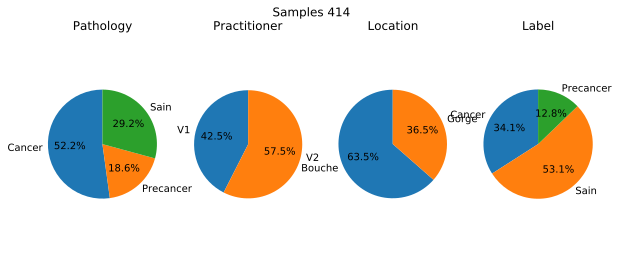

In [11]:
ViewsTools.plot_size((10, 4))
Views.statistics(inputs, statistics);

# Mean Analysis

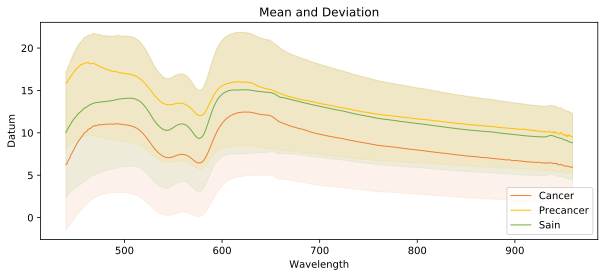

In [12]:
SignalsViews.mean_and_deviation(inputs, {'datum':'Datum', 'label':'Label', 'wavelength':'Wavelength'}, settings);

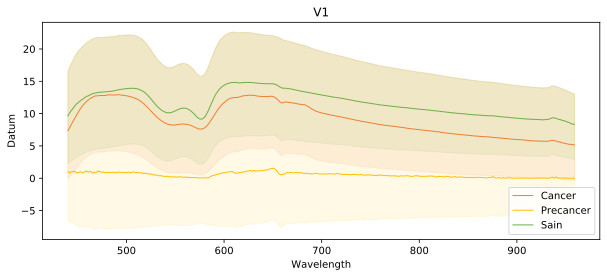

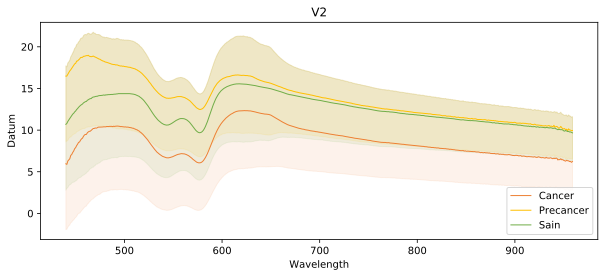

In [13]:
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V1'], {'datum':'Datum', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V1');
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V2'], {'datum':'Datum', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V2');

# Preprocessing

In [14]:
Tools.transform(inputs, {'datum': 'Datum'}, FilterTransform(5, 'avg'), 'Average')
Tools.transform(inputs, {'datum': 'Average'}, ScaleTransform('mean'), 'Scale')

# Preprocess - Mean Analysis

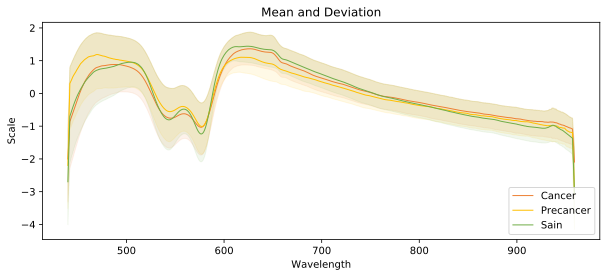

In [15]:
SignalsViews.mean_and_deviation(inputs, {'datum':'Scale', 'label':'Label', 'wavelength':'Wavelength'}, settings);

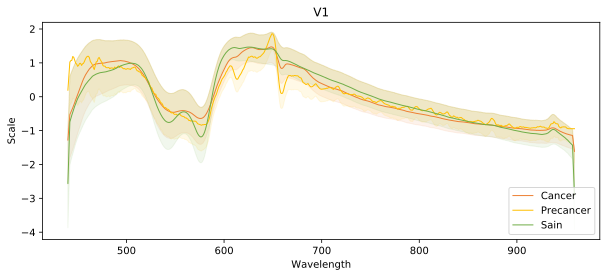

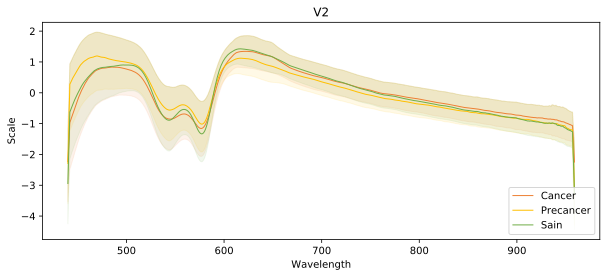

In [16]:
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V1'], {'datum':'Scale', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V1');
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V2'], {'datum':'Scale', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V2');

# Ratios Evaluation

## Model

In [17]:
model = SVC(kernel='linear', class_weight='balanced', probability=True)
grid = {'C': np.geomspace(0.01, 100, 5).tolist()}

## Litterature ratios
540 over 575 µm and 545 over 575 µm seems relevant

In [18]:
Tools.transform(inputs, {'datum': 'Scale'}, RatioTransform(ratios=[(540, 575), (545, 575)], wavelength=wavelength), 'LRatios')

In [19]:
Tools.evaluate(inputs, {'datum': 'LRatios', 'label_encode': 'LabelEncode'}, model, 'LRatios_SVM', grid=grid)

/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [20]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'LRatios_SVM'), {'label_encode': 'LabelEncode', 'eval': 'LRatios_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'LRatios_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'LRatios_SVM'}, label_encoder)],
                                    title=['Test - 540/575 and 545/575 Ratios classification performance.', 'Train - 540/575 and 545/575 Ratios classification performance']))

,precision,recall,f1-score,support
Sain,0.53±0.23,0.69±0.41,0.60±0.30,220.00±7.00
Precancer,0.10±0.11,0.06±0.12,0.07±0.11,53.00±5.49
Cancer,0.35±0.32,0.24±0.34,0.28±0.19,141.00±11.05
accuracy,0.45±0.12,0.45±0.12,0.45±0.12,0.45±0.12
macro avg,0.32±0.11,0.33±0.03,0.32±0.05,414.00±0.87
weighted avg,0.41±0.17,0.45±0.12,0.42±0.12,414.00±0.87
,precision,recall,f1-score,support
Sain,0.56±0.07,0.72±0.12,0.63±0.08,660.00±21.00
Precancer,0.32±0.21,0.15±0.08,0.20±0.11,159.00±16.48
Cancer,0.38±0.15,0.29±0.10,0.33±0.09,423.00±33.16


## Anova

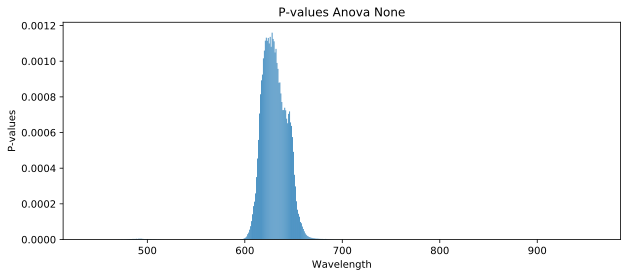

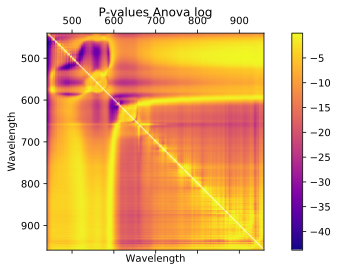

In [21]:
SignalsViews.analysis(inputs,  {'datum': 'Datum', 'wavelength': 'Wavelength', 'label_encode': 'Label'}, mode='Anova');
SignalsViews.analysis_relation(inputs,  {'datum': 'Datum', 'wavelength': 'Wavelength', 'label_encode': 'Label'}, scale='log', mode='Anova');

## Evaluate

In [22]:
Tools.transform(inputs, {'datum': 'Scale'}, RatioTransform(ratios=[(490, 525), (490, 560), (490, 590), (600, 620)], wavelength=wavelength), 'ORatios')

In [23]:
Tools.evaluate(inputs, {'datum': 'ORatios', 'label_encode': 'LabelEncode'}, model, 'ORatios_SVM', grid=grid)

/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [24]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'ORatios_SVM'), {'label_encode': 'LabelEncode', 'eval': 'ORatios_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'ORatios_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'ORatios_SVM'}, label_encoder)],
                                    title=['Test - 490/(525,560,590) and 600/620 Ratios classification performance.', 'Train - 490/(525,560,590) and 600/620 Ratios classification performance']))

,precision,recall,f1-score,support
Sain,0.65±0.03,0.72±0.27,0.68±0.15,220.00±7.00
Precancer,0.09±0.20,0.13±0.15,0.10±0.10,53.00±5.49
Cancer,0.62±0.05,0.40±0.07,0.48±0.06,141.00±11.05
accuracy,0.53±0.13,0.53±0.13,0.53±0.13,0.53±0.13
macro avg,0.45±0.08,0.42±0.09,0.42±0.07,414.00±0.87
weighted avg,0.57±0.03,0.53±0.13,0.54±0.07,414.00±0.87
,precision,recall,f1-score,support
Sain,0.64±0.06,0.67±0.07,0.65±0.03,660.00±21.00
Precancer,0.19±0.06,0.34±0.18,0.24±0.08,159.00±16.48
Cancer,0.65±0.08,0.40±0.06,0.49±0.02,423.00±33.16


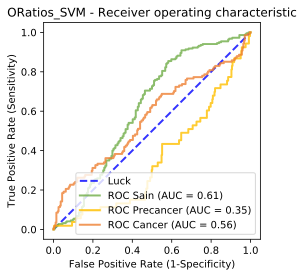

In [25]:
Views.receiver_operator_curves(ViewsTools.data_as(inputs, 'ORatios_SVM'), label_encoder, {'label_encode': 'LabelEncode', 'eval': 'ORatios_SVM'}, settings);

# PCA Evaluation

## Quick Analysis

Text(0.5, 1.0, 'PCA Analysis')

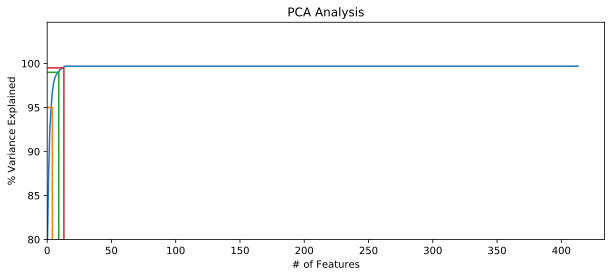

In [26]:
whole_pca = PCA().fit(np.array(inputs['Scale'].tolist()))
cumul = np.cumsum(np.round(whole_pca.explained_variance_ratio_, decimals=3)*100)
over_95 = np.argmax(cumul>95)
over_99 = np.argmax(cumul>99)
over_995 = np.argmax(cumul>99.5)
plt.plot(cumul)
plt.plot([0,over_95,over_95], [95,95,0])
plt.plot([0,over_99,over_99], [99,99,0])
plt.plot([0,over_995,over_995], [99.5,99.5,0])
plt.xlim(left=0)
plt.ylim(bottom=80)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')


## Model

In [27]:
pca95 = Pipeline([('pca', PCA(n_components=0.95)),
                  ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
pca99 = Pipeline([('pca', PCA(n_components=0.99)),
                  ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
pca995 = Pipeline([('pca', PCA(n_components=0.995)),
                  ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
grid_pca = {'clf__C': np.geomspace(0.01, 100, 5).tolist()}

## Evaluate

In [28]:
Tools.evaluate(inputs, {'datum': 'Scale', 'label_encode': 'LabelEncode'}, pca95, 'PCA95_SVM', grid=grid_pca)
Tools.evaluate(inputs, {'datum': 'Scale', 'label_encode': 'LabelEncode'}, pca99, 'PCA99_SVM', grid=grid_pca)
Tools.evaluate(inputs, {'datum': 'Scale', 'label_encode': 'LabelEncode'}, pca995, 'PCA995_SVM', grid=grid_pca)

/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [29]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'PCA95_SVM'), {'label_encode': 'LabelEncode', 'eval': 'PCA95_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'PCA95_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'PCA95_SVM'}, label_encoder)],
                                    title=['Test - PCA 95% classification performance.', 'Train - PCA 95% classification performance.']))

,precision,recall,f1-score,support
Sain,0.72±0.09,0.63±0.08,0.67±0.07,220.00±7.00
Precancer,0.25±0.15,0.55±0.28,0.34±0.18,53.00±5.49
Cancer,0.46±0.07,0.33±0.07,0.39±0.03,141.00±11.05
accuracy,0.52±0.05,0.52±0.05,0.52±0.05,0.52±0.05
macro avg,0.47±0.06,0.50±0.09,0.46±0.06,414.00±0.87
weighted avg,0.57±0.07,0.52±0.05,0.53±0.05,414.00±0.87
,precision,recall,f1-score,support
Sain,0.74±0.07,0.65±0.06,0.69±0.04,660.00±21.00
Precancer,0.29±0.10,0.64±0.03,0.40±0.10,159.00±16.48
Cancer,0.55±0.12,0.41±0.07,0.47±0.06,423.00±33.16


In [30]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'PCA99_SVM'), {'label_encode': 'LabelEncode', 'eval': 'PCA99_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'PCA99_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'PCA99_SVM'}, label_encoder)],
                                    title=['Test - PCA 99% classification performance.', 'Train - PCA 99% classification performance.']))

,precision,recall,f1-score,support
Sain,0.83±0.07,0.71±0.05,0.77±0.06,220.00±7.00
Precancer,0.44±0.12,0.72±0.11,0.55±0.12,53.00±5.49
Cancer,0.69±0.06,0.68±0.05,0.69±0.05,141.00±11.05
accuracy,0.70±0.02,0.70±0.02,0.70±0.02,0.70±0.02
macro avg,0.65±0.03,0.70±0.04,0.67±0.04,414.00±0.87
weighted avg,0.73±0.02,0.70±0.02,0.71±0.02,414.00±0.87
,precision,recall,f1-score,support
Sain,0.85±0.04,0.73±0.02,0.78±0.02,660.00±21.00
Precancer,0.45±0.10,0.82±0.11,0.58±0.10,159.00±16.48
Cancer,0.76±0.08,0.70±0.11,0.73±0.09,423.00±33.16


In [31]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'PCA995_SVM'), {'label_encode': 'LabelEncode', 'eval': 'PCA995_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'PCA995_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'PCA995_SVM'}, label_encoder)],
                                    title=['Test - PCA 99.5% classification performance.', 'Train - PCA 99.5% classification performance.']))

,precision,recall,f1-score,support
Sain,0.82±0.07,0.69±0.03,0.75±0.04,220.00±7.00
Precancer,0.40±0.07,0.74±0.14,0.52±0.07,53.00±5.49
Cancer,0.71±0.09,0.67±0.09,0.69±0.09,141.00±11.05
accuracy,0.69±0.04,0.69±0.04,0.69±0.04,0.69±0.04
macro avg,0.65±0.03,0.70±0.07,0.65±0.04,414.00±0.87
weighted avg,0.73±0.05,0.69±0.04,0.70±0.04,414.00±0.87
,precision,recall,f1-score,support
Sain,0.87±0.04,0.73±0.03,0.80±0.03,660.00±21.00
Precancer,0.43±0.10,0.86±0.09,0.57±0.10,159.00±16.48
Cancer,0.80±0.05,0.69±0.12,0.74±0.08,423.00±33.16


In [46]:
ViewsTools.data_as(inputs, 'PCA99_SVM')

,Diagnosis,ID_Spectrum,Datum,Wavelength,Category,Reference,Identifier,Patient,Pathology,Practitioner,...,Fit_SVM_Features_3,Fit_SVM_Parameters_3,Fit_SVM_Prediction_4,Fit_SVM_Probability_4,Fit_SVM_Features_4,Fit_SVM_Parameters_4,Fit_SVM_Prediction,Fit_SVM_Probability,Fit_SVM_Features,Fit_SVM_Parameters
0,Cancer,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
1,Cancer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.276...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
2,Cancer,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
3,Cancer,3,"[20.320190215924416, 20.92858036437247, 22.484...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
4,Sain,4,"[7.8820947368421095, 8.048337179487184, 8.2492...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578518, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578518, 0.29...",2.0,{'C': 0.01}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Sain,1,"[8.42337914979757, 8.787305398110663, 9.053957...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,15_C.M,15,C.M,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.4418998077432791, 0.13695467363496766, 0.42...",2.0,{'C': 0.01}
378,Sain,2,"[15.692028475033734, 15.921782186234818, 16.19...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,15_C.M,15,C.M,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.4418998077432791, 0.13695467363496766, 0.42...",2.0,{'C': 0.01}
379,Sain,3,"[11.623876990553319, 11.968237044534416, 11.96...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,15_C.M,15,C.M,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.4418998077432791, 0.13695467363496766, 0.42...",2.0,{'C': 0.01}
380,Sain,4,"[4.332473481781375, 4.603913967611337, 4.52115...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,15_C.M,15,C.M,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.4418998077432791, 0.13695467363496766, 0.42...",2.0,{'C': 0.01}


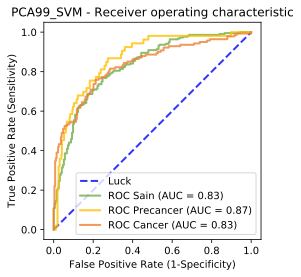

In [32]:
Views.receiver_operator_curves(ViewsTools.data_as(inputs, 'PCA99_SVM'), label_encoder, {'label_encode': 'LabelEncode', 'eval': 'PCA99_SVM'}, settings);

In [33]:
from sklearn.metrics import auc, roc_curve
import csv

# Data
labels = np.array(inputs['LabelEncode'].to_list())
unique = np.unique(inputs['LabelEncode'])
probabilities = np.array(inputs[f'PCA99_SVM_{Tools.PROBABILITY}'].to_list())

# Browse each label
for positive_index in unique:
    positive_class = label_encoder.inverse_transform(positive_index)[0]
    fpr, tpr, threshold = roc_curve(labels, probabilities[:, positive_index], pos_label=positive_index)
    a = np.asarray([threshold, fpr, tpr ])
    np.savetxt(f"{label_encoder.inverse_transform(positive_index)[0]}.csv", a, delimiter=",")
    
inputs[['Patient','Pathology','Practitioner','ID_Spectrum','Diagnosis',f'PCA99_SVM_{Tools.PROBABILITY}']].to_csv('Recapitulatif.csv', index = False)



# DWT and Bags Evaluation

## Transform

In [34]:
Tools.transform(inputs, {'datum': 'Scale'}, DWTTransform(mode='db6', segment=80), 'DWT')

## Model

In [35]:
pipe_ahmed = Pipeline([('kmeans', KMeans(n_clusters=92, max_iter=50)),
                       ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
grid_ahmed = {'clf__C': np.geomspace(0.01, 100, 5).tolist()}

In [36]:
Tools.evaluate(inputs, {'datum': 'DWT', 'label_encode': 'LabelEncode'}, pipe_ahmed, 'DWT_SVM', grid=grid_ahmed)

/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [37]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'DWT_SVM'), {'label_encode': 'LabelEncode', 'eval': 'DWT_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'DWT_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'DWT_SVM'}, label_encoder)],
                                    title=['Test - DWT+BOW classification performance.', 'Train - DWT+BOW classification performance.']))

,precision,recall,f1-score,support
Sain,0.77±0.07,0.75±0.05,0.76±0.05,220.00±7.00
Precancer,0.37±0.13,0.51±0.20,0.43±0.14,53.00±5.49
Cancer,0.70±0.12,0.62±0.03,0.66±0.07,141.00±11.05
accuracy,0.68±0.03,0.68±0.03,0.68±0.03,0.68±0.03
macro avg,0.61±0.05,0.63±0.07,0.62±0.05,414.00±0.87
weighted avg,0.70±0.03,0.68±0.03,0.68±0.03,414.00±0.87
,precision,recall,f1-score,support
Sain,0.89±0.03,0.83±0.03,0.86±0.03,660.00±21.00
Precancer,0.56±0.15,0.94±0.05,0.70±0.12,159.00±16.48
Cancer,0.87±0.03,0.75±0.10,0.81±0.05,423.00±33.16


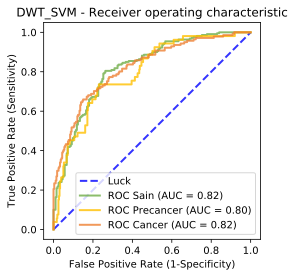

In [38]:
Views.receiver_operator_curves(ViewsTools.data_as(inputs, 'DWT_SVM'), label_encoder, {'label_encode': 'LabelEncode', 'eval': 'DWT_SVM'}, settings);

# Distribution Evaluation

## Analysis

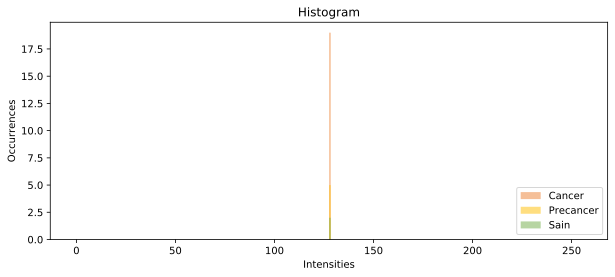

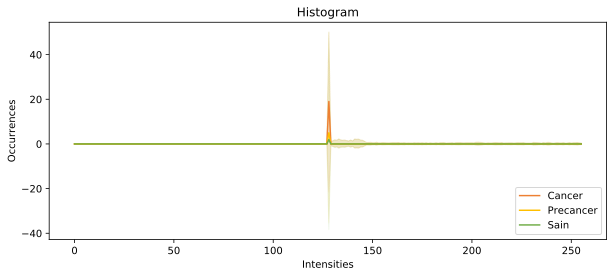

In [39]:
SignalsViews.histogram(inputs, {'datum': 'Datum', 'label': 'Label'}, settings);
SignalsViews.histogram(inputs, {'datum': 'Datum', 'label': 'Label'}, settings, mode='std');

## Transform

In [40]:
fit = FittingTransform().fit(np.array(inputs['Scale'].tolist()))
Tools.transform(inputs, {'datum': 'Scale'}, fit, 'Fit')

## Evaluate

In [41]:
Tools.evaluate(inputs, {'datum': 'Fit', 'label_encode': 'LabelEncode'}, model, 'Fit_SVM', grid=grid)

/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/rcendre/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [42]:
Views.report(ViewsTools.data_as(inputs, 'Fit_SVM'), {'label_encode': 'LabelEncode', 'eval': 'Fit_SVM'}, label_encoder)

,precision,recall,f1-score,support
Sain,0.54±0.24,0.75±0.43,0.63±0.31,220.00±7.00
Precancer,0.12±0.05,0.25±0.43,0.17±0.10,53.00±5.49
Cancer,0.00±0.00,0.00±0.00,0.00±0.00,141.00±11.05
accuracy,0.43±0.19,0.43±0.19,0.43±0.19,0.43±0.19
macro avg,0.22±0.06,0.33±0.00,0.26±0.07,414.00±0.87
weighted avg,0.30±0.14,0.43±0.19,0.35±0.17,414.00±0.87


In [43]:
Views.report(ViewsTools.data_as(inputs, 'Fit_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'Fit_SVM'}, label_encoder)

,precision,recall,f1-score,support
Sain,0.53±0.06,0.75±0.14,0.62±0.06,660.00±21.00
Precancer,0.13±0.08,0.25±0.14,0.17±0.09,159.00±16.48
Cancer,0.00±0.00,0.00±0.00,0.00±0.00,423.00±33.16
accuracy,0.43±0.08,0.43±0.08,0.43±0.08,0.43±0.08
macro avg,0.22±0.04,0.33±0.00,0.26±0.03,1242.00±2.60
weighted avg,0.30±0.08,0.43±0.08,0.35±0.07,1242.00±2.60


<BarContainer object of 17 artists>

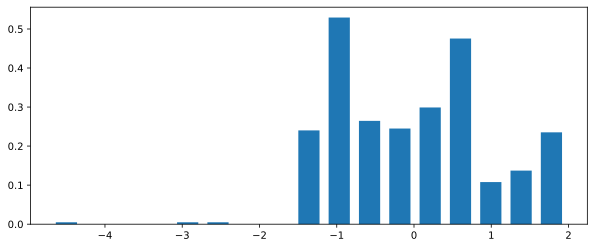

In [44]:
import scipy.stats as st
# plt.plot(inputs['Wavelength'][0], inputs['Datum'][0])
hist, bins = np.histogram(inputs['Scale'][7], bins='auto', density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

In [45]:
inputs

,Diagnosis,ID_Spectrum,Datum,Wavelength,Category,Reference,Identifier,Patient,Pathology,Practitioner,...,Fit_SVM_Features_3,Fit_SVM_Parameters_3,Fit_SVM_Prediction_4,Fit_SVM_Probability_4,Fit_SVM_Features_4,Fit_SVM_Parameters_4,Fit_SVM_Prediction,Fit_SVM_Probability,Fit_SVM_Features,Fit_SVM_Parameters
0,Cancer,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
1,Cancer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.276...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
2,Cancer,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
3,Cancer,3,"[20.320190215924416, 20.92858036437247, 22.484...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
4,Sain,4,"[7.8820947368421095, 8.048337179487184, 8.2492...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578518, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578518, 0.29...",2.0,{'C': 0.01}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Sain,1,"[6.01937705802969, 6.53151214574899, 6.8970527...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,20_T.C,20,T.C,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
410,Sain,2,"[7.850063090418356, 8.068306342780026, 8.51894...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,20_T.C,20,T.C,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
411,Sain,3,"[4.835539946018897, 5.116684075573551, 5.53736...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,20_T.C,20,T.C,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578515, 0.29...",2.0,{'C': 0.01}
412,Sain,4,"[0.0, 0.0, 0.05530057263370873, 0.160717796152...","[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Temoins,20_T.C,20,T.C,Sain,V1,...,2,{'C': 0.01},0,"[0.5304533597290496, 0.17155488746578518, 0.29...",2,{'C': 0.01},0.0,"[0.5304533597290496, 0.17155488746578518, 0.29...",2.0,{'C': 0.01}
